In [1]:
# AMP decoder for signal recovery in compressed sensing.
# CS model: y = Ax + noise
# Goal: recover x given y and A
#
# Compare the empirical average mean-squared error (MSE) of AMP 
# decoding over many random decoding instances with its prediction 
# from state evolution (SE).
# 1) We compare the MSE across iterations for a single set of system
#    parameters.
# 2) We compare the undersampling ratio vs sparisty ratio (final 
#    iteration) MSE phase diagram.
#
# Copyright (c) 2021 Kuan Hsieh

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
from matplotlib.colors import LogNorm
from amp4cs import initialise_CS, opt_tuning_param, amp, se

# Single instance

In [2]:
N     = 1000  # dimension of signal
M     = 500  # num of measurements
K     = 30   # num of non-zero coefficients
sigma = 0.05  # Noise standard deviation

delta    = M/N
eps      = K/N
alpha    = opt_tuning_param(eps) # Find optimal alpha
iter_max = 20 # Max num of iterations

In [3]:
# Run AMP decoder 

numOfRuns = 10
mse       = np.ones((numOfRuns, iter_max)) * eps

for run in range(numOfRuns):
    
    y, A, x_init = initialise_CS(N, M, K, sigma)
    x_amp = np.zeros_like(x_init) # Initial signal estimate
    z_amp = y                     # Initial residual
    mse[run] = np.var(x_init)*np.ones(iter_max) # Store empirical MSE across iterations

    for t in range(iter_max-1):
        (x_amp, z_amp)   = amp(y, A, x_amp, z_amp, alpha)
        mse[run,t+1] = np.mean((x_amp-x_init)**2)

In [6]:
# State evolution, tau here is a variance not standard deviation
# (a squared difference)

nsamples = 1000000
psi,_ = se(eps, delta, sigma, iter_max, nsamples)

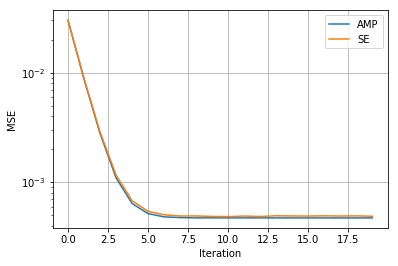

In [7]:
plt.plot(mse.mean(axis=0), label='AMP')
plt.plot(psi, label='SE')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid()
plt.legend()

# Undersampling-sparsity MSE phase diagram

In [8]:
start = time.perf_counter()

N         = 500   # Dimension of signal
iter_max  = 50    # Iteration limit
numOfRuns = 30    # Number of runs to calculate the median
sigma     = 0.025 # Noise standard deviation

n     = 20 # Number of equispaces samples on each axis of the graph
rho   = np.linspace(1/n, 1, n) # sparsity ratios
delta = np.linspace(1/n, 1, n) # undersampling ratios

nsamples    = 100000 # Number of Monte Carlo samples for SE
errStore    = np.ones(numOfRuns)*np.nan # Store error in estimation for each run
errArray    = np.ones((n,n))*np.nan     # Store error in estimation for each delta, alpha
errArray_se = np.ones((n,n))*np.nan     # Store error in estimation for each delta, alpha

for i in range(n):
    if (np.around(delta[i]*100) % 20) == 0:
        print(str(np.around(delta[i]*100))+"%")

    for j in range(n):
        eps   = delta[i]*rho[j]
        alpha = opt_tuning_param(eps)
        
        # AMP 
        for run in range(numOfRuns):
            M = np.around(N * delta[i]).astype(int)
            K = np.around(M * rho[j]).astype(int)
            
            y, A, x_init = initialise_CS(N, M, K, sigma, x_choice=0)

            # AMP decoding
            x_amp   = np.zeros_like(x_init) # Initial signal estimate
            z_amp   = y                     # Initial residual
            for t in range(iter_max):
                (x_amp, z_amp)     = amp(y, A, x_amp, z_amp, alpha)
                
            errStore[run]   = np.mean((x_amp-x_init)**2) 
        errArray[j,i]    = np.median(errStore)   # Note swap of i & j since rhos are rows
        
        # SE
        psi,_ = se(eps, delta[i], sigma, iter_max, nsamples)
        errArray_se[j,i] = psi[-1]

print("time elapsed (s):", time.perf_counter()-start)   

20.0%
40.0%
60.0%
80.0%
100.0%
time elapsed (s): 238.27061785000004


Text(0, 0.5, '$\\rho = K/M$')

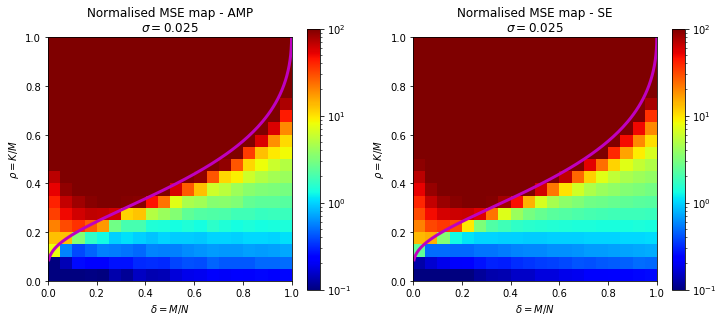

In [9]:
# This is the Donoho-Tanner phase transition curve
alpha2 = np.linspace(0,3,300)
delta2 = 2*norm.pdf(alpha2)/(alpha2+2*(norm.pdf(alpha2)-alpha2*norm.cdf(-alpha2)))
rho2   = 1 - alpha2*norm.cdf(-alpha2)/norm.pdf(alpha2)

# Plot the MSE phase diagrams
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(delta2, rho2,'m', linewidth=3.0)
plt.imshow(errArray/sigma**2, norm=LogNorm(vmin=1e-1, vmax=1*1e2), cmap='jet',
           interpolation='none', origin='lower', extent=(0,1,0,1))
# plt.imshow(errArray, interpolation='none', origin='lower', extent=(0,1,0,1))
plt.title('Normalised MSE map - AMP' +'\n'+ r'$\sigma=$'+str(sigma))
plt.colorbar(shrink=0.8)
plt.xlabel(r'$\delta = M/N$')
plt.ylabel(r'$\rho = K/M$')

plt.subplot(122)
plt.plot(delta2, rho2, 'm',linewidth=3.0)
plt.imshow(errArray_se/sigma**2, norm=LogNorm(vmin=1e-1, vmax=1*1e2), cmap='jet',
           interpolation='none', origin='lower', extent=(0,1,0,1))
# plt.imshow(errArray_b/sigma**2, cmap='jet', interpolation='none', origin='lower', extent=(0,1,0,1))
plt.title('Normalised MSE map - SE' +'\n'+ r'$\sigma=$'+str(sigma))
plt.colorbar(shrink=0.8)
plt.xlabel(r'$\delta = M/N$')
plt.ylabel(r'$\rho = K/M$')